[Looking at someone's code on kaggle](https://www.kaggle.com/asindico/a-japanese-journey/notebook)

In [1]:
import numpy as np
import pandas as pd
from subprocess import check_output
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
sns.set(font_scale=2)
%matplotlib inline

In [2]:
from mapboxgl.viz import *
from mapboxgl.utils import *

In [3]:
# Must be a public token, starting with `pk`
token = 'pk.eyJ1IjoiYW5kZTg2MDkiLCJhIjoiY2psbzNmbjN2MXBrYjNrb3M0ZnpwNXM5biJ9.ap0AV9slM0h57R-A7Qsq4w'

# Thoughts
- I want to get a shapefile for Japan and plot out where all of the restaraunts in the dataset are in the country.

# Data Wrangling

In [12]:
# This has the number of visitors that had a reservation
airres = pd.read_csv('air_reserve.csv')
# This has all of the basic information about each store
airstore = pd.read_csv('air_store_info.csv')
# This is the number of visitors that made reservations
hpgres1 = pd.read_csv('hpg_reserve_1.csv')
hpgres2 = pd.read_csv('hpg_reserve_2.csv')
# The hpg_reserve.csv file got split mid-line, this fixes that line
hpgres1.iloc[-1,0] += hpgres2.iloc[0,0]
hpgres1.iloc[-1,1:] = hpgres2.iloc[0,1:]
# Throwing all the hpg_reserve data into a single dataframe
hpgres = pd.concat([hpgres1, hpgres2.iloc[1:,:]], ignore_index=True)
del hpgres1, hpgres2
# This has basic information
hpgstore = pd.read_csv('hpg_store_info.csv')
# This is where the visitor data lives
airvisit = pd.read_csv('air_visit_data.csv')
dates = pd.read_csv('date_info.csv')
rel = pd.read_csv('store_id_relation.csv')

Merging all of the data together.

In [7]:
air = pd.merge(airres, airstore, on='air_store_id')
del airres, airstore
hpg = pd.merge(hpgres, hpgstore, on='hpg_store_id')
del hpgres, hpgstore
airrel = pd.merge(air, rel, how='left', on='air_store_id')
del air
hpgrel = pd.merge(hpg, rel, how='left', on='hpg_store_id')
del hpg
full = pd.merge(airrel, hpgrel, how='outer')
del airrel, hpgrel

In [8]:
full['visit_datetime'] = pd.to_datetime(full.visit_datetime)
full['reserve_datetime'] = pd.to_datetime(full.reserve_datetime)
full['visit_date'] = pd.to_datetime(full.visit_datetime.dt.date)
full['reserve_date'] = full.reserve_datetime.dt.date
#full['visit_weekday'] = full.visit_datetime.dt.weekday_name
full['visit_dayofweek'] = full.visit_datetime.dt.dayofweek
full['visit_dayofyear'] = full.visit_datetime.dt.dayofyear
#full['reserve_weekday'] = full.reserve_datetime.dt.weekday_name
full['reserve_dayofweek'] = full.reserve_datetime.dt.dayofweek
full['reserve_dayofyear'] = full.reserve_datetime.dt.dayofyear
full['time_diff'] = full.visit_datetime - full.reserve_datetime

Pulling in Holiday information and adding it to the full dataframe.

In [9]:
dates['calendar_date'] = pd.to_datetime(dates.calendar_date)
dates['visit_dayofyear'] = dates.calendar_date.dt.dayofyear

In [10]:
full = pd.merge(full,
                dates[['calendar_date', 'holiday_flg']],
                how='left',
                left_on='visit_date',
                right_on='calendar_date')
del dates

Clustering based on geography and adding the cluster number to the full dataframe.

In [11]:
#```python
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(full[['longitude', 'latitude']])
full['cluster'] = kmeans.predict(full[['longitude', 'latitude']])
#```

### Looking at a sample of the dataset

In [12]:
_testdf = full.sample(10000, axis=0)

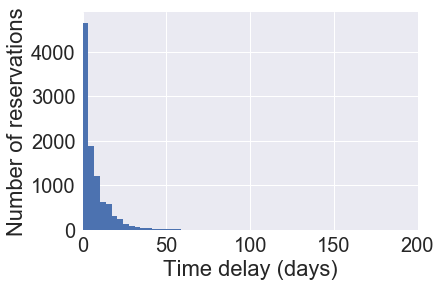

In [13]:
(_testdf.time_diff / pd.Timedelta(days=1)).hist(bins=100)
plt.xlabel("Time delay (days)")
plt.ylabel("Number of reservations")
plt.xlim(0, 200)
None

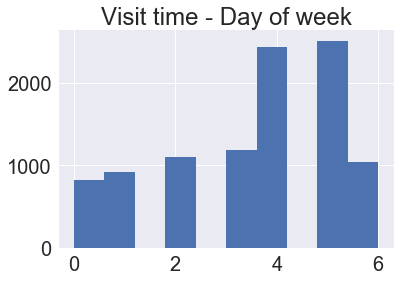

In [14]:
_testdf.visit_dayofweek.hist()
plt.title('Visit time - Day of week')
None

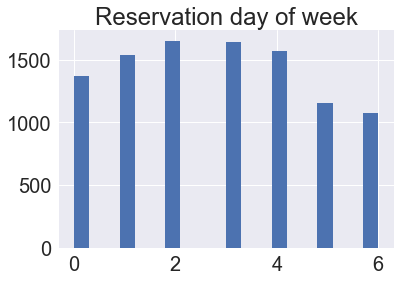

In [15]:
_testdf.reserve_dayofweek.hist(bins=20)
plt.title('Reservation day of week')
None

In [16]:
full.hpg_store_id.dropna().sample(1)

465059    hpg_489d699e6baaa667
Name: hpg_store_id, dtype: object

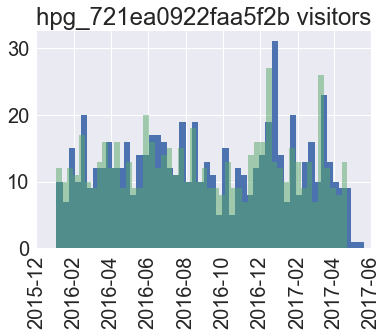

In [17]:
_id = full.hpg_store_id.dropna().sample(1).values[0]
full[full.hpg_store_id == _id].visit_datetime.hist(bins=50)
full[full.hpg_store_id == _id].reserve_datetime.hist(bins=50, alpha=.5)
plt.xticks(rotation=90)
plt.title(_id+' visitors')
plt.xlim([datetime.date(2015, 12, 1), datetime.date(2017, 6, 1)])
None

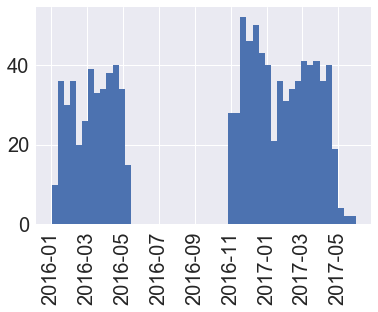

In [18]:
full[full.air_store_id == 'air_877f79706adbfb06'].visit_datetime.hist(bins=50)
plt.xticks(rotation=90)
None

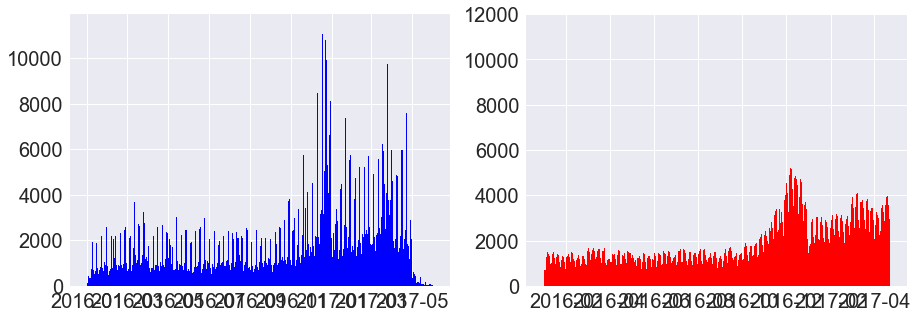

In [19]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(15, 5))
full.visit_datetime.hist(bins=500, color='blue', ax=ax0)
full.reserve_datetime.hist(bins=500, color='red', ax=ax1)
ax1.set_ylim(0,12000)
#ax0.set_xticks(rotation=90)
#plt.xlim([datetime.date(2016, 1, 26), datetime.date(2016, 2, 1)])
None

In [20]:
data = df_to_geojson(_testdf.fillna(''),
                     properties=['hpg_genre_name', 'hpg_area_name', 'air_area_name', 'air_genre_name', 'reserve_visitors', 'cluster'],
                     precision=4,
                     lat='latitude',
                     lon='longitude')

In [21]:
color_breaks = list(range(9))
color_stops = create_color_stops(color_breaks, colors='YlGnBu')
# Initialize CircleViz with Categorical Measure Data
viz = CircleViz(data, 
                access_token=token,
                height='500px',
                label_property='cluster',
                color_property='cluster',
                color_stops=color_stops,
                radius=2,
                center=(137.5, 38),
                zoom=4,
                opacity=.1)

# Render map
viz.show() 

In [22]:
def plot_days(df):
    f, [ax0, ax1] = plt.subplots(1, 2, figsize=(15, 5))
    _hist_day = df.groupby('visit_dayofweek', as_index=True).count()
    ax0.bar(_hist_day.index, _hist_day.air_store_id)
    ax1.bar(_hist_day.index, _hist_day.hpg_store_id)
    ax0.set_xlabel("Weekday (Monday to Sunday)")
    ax1.set_xlabel("Weekday (Monday to Sunday)")
    ax0.set_ylabel("Count")

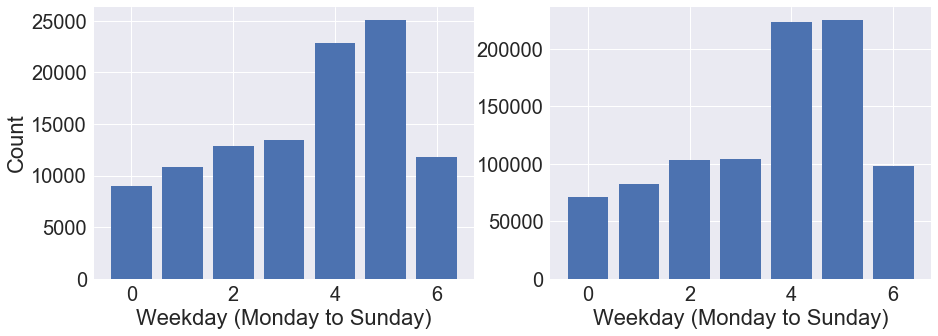

In [23]:
plot_days(full)

In [24]:
def plot_cluster(df):
    f, [ax0, ax1] = plt.subplots(1,2,figsize=(15, 6))
    hist_clust = df.groupby(['cluster'], as_index=False).count()
    ax0.bar(hist_clust.cluster, hist_clust.air_store_id)
    ax1.bar(hist_clust.cluster, hist_clust.hpg_store_id)
    ax0.set_ylabel("Count")
    ax0.set_xlabel("Cluster")
    ax0.set_xlabel("Cluster")

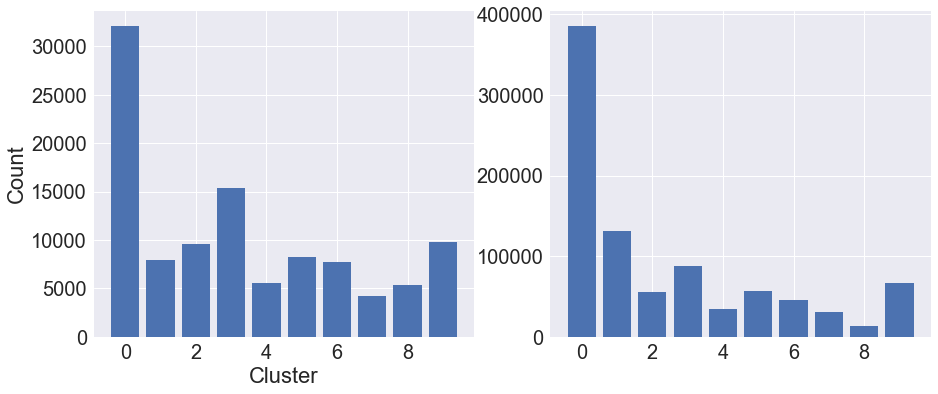

In [25]:
plot_cluster(full)

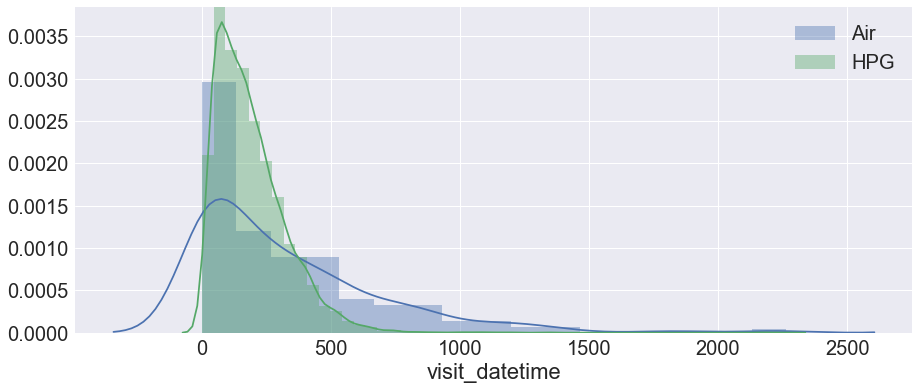

In [26]:
f, ax = plt.subplots(1, 1, figsize=(15, 6))
airhist = full.groupby(['air_store_id'], as_index=False).count()
sns.distplot(airhist.visit_datetime, label='Air')
hpghist = full.groupby(['hpg_store_id'], as_index=False).count()
sns.distplot(hpghist.visit_datetime, label='HPG')
plt.legend()
None

## Cuisine Genres

In [27]:
air_genre = full.loc[full.air_genre_name.isnull()==False].groupby(['cluster', 'air_genre_name'], as_index=False).count()
hpg_genre = full.loc[full.hpg_genre_name.isnull() == False].groupby(['cluster', 'hpg_genre_name'], as_index=False).count()

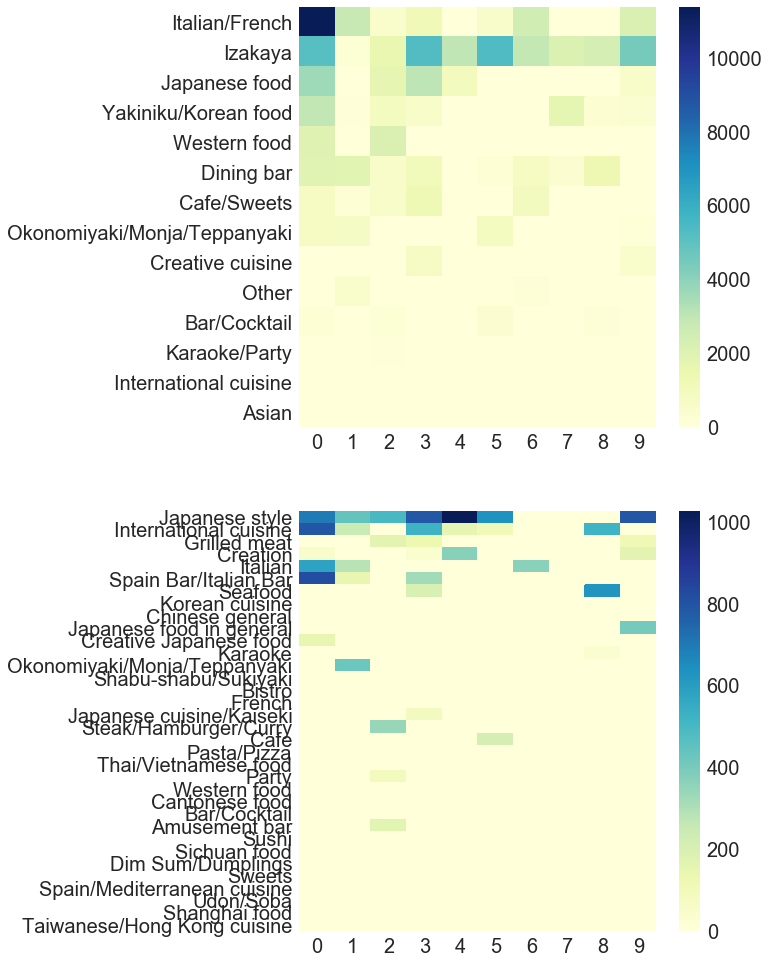

In [28]:
# PLOTTING
f, [ax0, ax1] = plt.subplots(2, 1, figsize = (8, 17))

genres = air_genre.sort_values('air_store_id', ascending=False).air_genre_name.unique()
hm = np.zeros((len(genres), 10))

for j in range(10):
    for i, name in enumerate(genres):
        if name in air_genre.loc[air_genre.cluster==j].air_genre_name.values:
            hm[i,j] = air_genre.loc[air_genre.cluster==j].loc[air_genre.air_genre_name==name]['air_store_id'].values[0]
        else:
            pass

#hm = pd.DataFrame(hm, index=genres,)

# Plotting Air Data
sns.heatmap(hm, cmap='YlGnBu', yticklabels=genres, ax=ax0)

genres = hpg_genre.sort_values('hpg_store_id', ascending=False).hpg_genre_name.unique()
hm = np.zeros((len(genres), 10))

for j in range(10):
    for i, name in enumerate(genres):
        if name in hpg_genre.loc[hpg_genre.cluster==j].hpg_genre_name.values:
            hm[i,j] = hpg_genre.loc[hpg_genre.cluster==j].loc[hpg_genre.hpg_genre_name==name]['air_store_id'].values[0]
        else:
            pass

#hm = pd.DataFrame(hm, index=genres,)

# Plotting Air Data
sns.heatmap(hm, cmap='YlGnBu', yticklabels=genres, ax=ax1)


None

## Japanese Holidays

Does the day that people visit change when its a holiday?

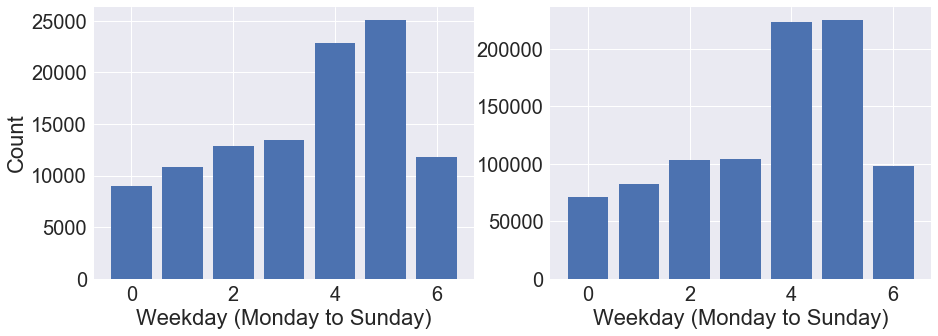

In [29]:
plot_days(full)

Normalize by how many time a holiday falls on a given day of the week.

In [30]:
hist_clust = df.groupby(['cluster'], as_index=False).count()



NameError: name 'df' is not defined

In [ ]:
plot_days(full[full.holiday_flg == 1])

In [ ]:
plot_days(full[full.holiday_flg == 0])

In [ ]:
plot_cluster(full)

In [ ]:
plot_cluster(full[full.holiday_flg == 1])

In [ ]:
plot_cluster(full[full.holiday_flg == 0])